Team member: Janki

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Mount Google Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')

# Read CSV files into DataFrames
folder_path = '/content/drive/MyDrive/CS418_Project/data/Data_wStocks/'
data_2020 = pd.read_csv(folder_path + 'rank_name_symbol_2020.csv')
data_2021 = pd.read_csv(folder_path + 'rank_name_symbol_2021.csv')
data_2022 = pd.read_csv(folder_path + 'rank_name_symbol_2022.csv')
data_2023 = pd.read_csv(folder_path + 'rank_name_symbol_2023.csv')

# Combine the yearly data into a single DataFrame
data = pd.concat([data_2020, data_2021, data_2022, data_2023])

# Cleaning 'Profit' and 'Revenue' columns
def clean_financial_column(df, column_name):
    df[column_name] = df[column_name].replace('[\$,()]', '', regex=True).astype(float)

for column in ['Profit', 'Revenue']:
    clean_financial_column(data, column)

# Encode categorical variables
categorical_columns = ['Name', 'Ticker', 'Sector', 'Industry']  # Adjust as needed
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Defining Revenue Categories based on quantiles
revenue_labels = ['Low', 'Medium', 'High']
data['Revenue Category'] = pd.qcut(data['Revenue'], q=3, labels=revenue_labels)

# Drop rows with NaN values in any column
data_cleaned = data.dropna()

# Preparing features and target variable
features = data_cleaned.drop(['Revenue', 'Revenue Category'], axis=1)  # Drop non-feature columns
target = data_cleaned['Revenue Category']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
numerical_cols = features.select_dtypes(include=['float64']).columns  # Adjust to your numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Initialize and train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))
# Make predictions



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
              precision    recall  f1-score   support

        High       0.96      0.95      0.96       108
         Low       0.95      0.98      0.96       125
      Medium       0.93      0.91      0.92       121

    accuracy                           0.95       354
   macro avg       0.95      0.95      0.95       354
weighted avg       0.95      0.95      0.95       354



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

# Load and combine data
folder_path = '/content/drive/MyDrive/CS418_Project/data/Data_wStocks/'
files = ['rank_name_symbol_2020.csv', 'rank_name_symbol_2021.csv', 'rank_name_symbol_2022.csv']
data = pd.concat([pd.read_csv(folder_path + file) for file in files])

# Clean 'Revenue' column
data['Revenue'] = data['Revenue'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Remove extreme outliers in 'Revenue' based on z-scores
data = data[(np.abs(zscore(data['Revenue'])) < 3)]

# Add some potential feature transformations or new features
data['LogRevenue'] = np.log1p(data['Revenue'])  # Log transformation

# Define X and y
X = data.drop(['Revenue', 'LogRevenue'], axis=1)  # Drop original Revenue to avoid leakage
y = data['LogRevenue']  # Use LogRevenue as target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline setup
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# RandomForestRegressor with a wider range of parameters
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_distributions = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    pipeline, param_distributions, n_iter=20, cv=5, n_jobs=-1,
    scoring='neg_mean_squared_error', random_state=42, error_score='raise'
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Convert predictions back from log scale
y_pred_exp = np.expm1(y_pred)
y_test_exp = np.expm1(y_test)

mse = mean_squared_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)

print(f'Best Model Parameters: {random_search.best_params_}')
print(f'R2 score: {r2}')
print(f'Mean Squared Error: {mse}')


Best Model Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None}
R2 score: 0.9947204659051088
Mean Squared Error: 3323187.7753307833


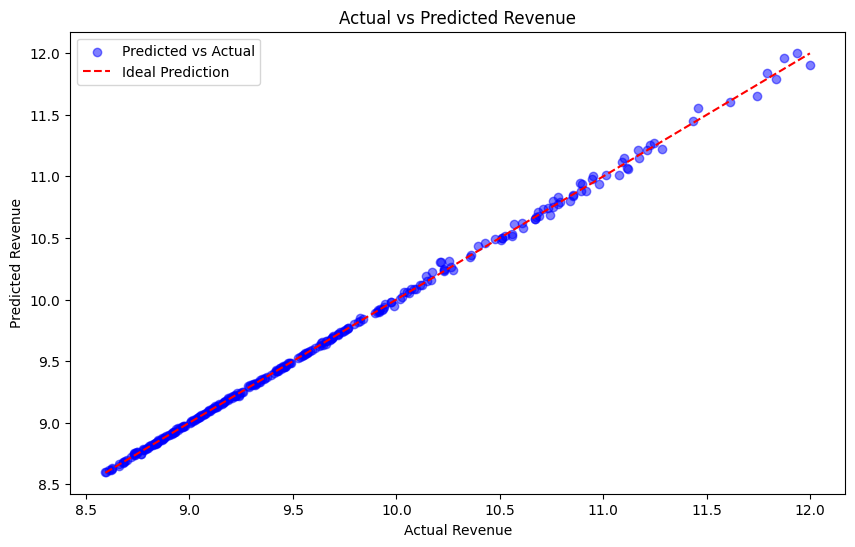

In [3]:
import matplotlib.pyplot as plt

# Plot predicted vs actual revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Ideal Prediction')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()  # This line adds the legend to the plot
plt.show()


# The image depicts a scatter plot graphically comparing log-transformed predicted revenue against log-transformed actual revenue from a RandomForestRegressor machine learning model. On this plot, the x-axis and y-axis represent the actual and predicted revenues, respectively, suggesting both sets of figures have undergone a logarithmic transformation to mitigate data skewness and facilitate better interpretation. The plotted blue dots, denoting individual predictive data points, cluster tightly along a red dashed line which serves as the benchmark for perfect predictions, signifying a high degree of accuracy in the model's revenue forecasting ability. This accuracy is underscored by a legend distinguishing the blue dots as the "Predicted vs Actual" revenue and the red line as the "Ideal Prediction." The accompanying statistical results yield an R2 score close to 0.995, indicating an exceptional 99.5% variance explained by the model, and a Mean Squared Error (MSE) of roughly 3,323,187.77, which measures the average squared deviation between predicted and actual revenues, though this figure should be contextualized within the bounds of the logarithmic scale applied. Complementing the visualization, the provided code is part of a Python script which methodically carries out data procurement, cleansing, including outlier exclusion, and establishment of a preprocessing pipeline complete with hyperparameter tuning via randomized search, culminating in the performance evaluation of the model using R2 and MSE, and the display of optimized model parameters.